
Data Understanding

The data we will use to perform this analysis was obtained from Kaggle dataset dataset which was obtained via the Riot API. It includes data from 9,879 high ranking (Diamond I to Master) competitive matches with 19 features per team and one target variable which indicates whether the match resulted in a win for the blue team.

Glossary of Features:

    Ward: An item that players can place on the map to reveal the nearby area. Very useful for map/objectives control.

    Assist: Awards partial gold and experience points when damage is done to contribute to an enemy's death.

    Elite Monsters: Monsters with high hp/damage that give a massive bonus (gold/XP/stats) when killed by a team.

    Dragon: AKA Drake. This powerful neutral monster grants various permanent effects and buffs when when killed by a team.

    Herald: A monster that spawns on the eigth minute. Grants a buff that allows the user to spawn the Herald for your team to help push towers and lanes.

    Tower: A structure that blocks the enemy’s path to the base. They take high damage and fire at opponents within a certain radius.

    Gold: Currency awarded for killing monsters or enemy players as well as for completing objectives.

    Level: Champion level. Start at 1. Max is 18.

    Minions: Non-player characters (NPCs) that spawn from each team’s base.
    
    Jungle Minions: NPC that belong to NO TEAM. They give gold and temporary buffs when killed by players.



In [150]:
from sklearn import metrics
import warnings
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.gridspec import GridSpec
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(42)


warnings.filterwarnings('ignore')

%matplotlib inline




In [151]:
df = pd.read_csv('..\\data\\interim\\lol_clean_data.csv')
df.describe()
non_std_df = df



df.info()

In [152]:
# Creating new dfs 
target_df = df.loc[:,'blueWins']
no_target_df = df.loc[:, df.columns != 'blueWins']
target_df

0       0
1       0
2       0
3       0
4       0
       ..
9874    1
9875    1
9876    0
9877    0
9878    1
Name: blueWins, Length: 9879, dtype: int64

# Standardizing dataset


In [153]:
# Making a Scaler obj
sc = preprocessing.StandardScaler()
scaled_df = sc.fit_transform(no_target_df)
scaled_df = pd.DataFrame(scaled_df, columns=no_target_df.columns)
df = pd.concat([target_df,scaled_df], axis=1)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,0.316996,-0.379275,0.990429,0.935301,-0.046926,1.071495,-0.753226,-0.481132,-0.210439,...,-0.198353,0.052293,-0.410475,-0.763215,-0.928741,0.367685,-0.256228,-0.013342,-0.928741,0.052293
1,0,-0.570992,-0.839069,-1.009663,-0.393216,-0.387796,-0.404768,-0.753226,-0.481132,-0.210439,...,4.412301,0.758619,-0.410475,-0.436980,1.033784,0.068504,1.191254,0.593342,1.033784,0.758619
2,0,-0.404494,-1.298863,-1.009663,0.271042,1.657424,-0.650812,1.327623,-0.481132,-0.210439,...,-0.198353,0.533909,-0.410475,-0.590502,-0.654900,-2.324944,0.483614,0.520436,-0.654900,0.533909
3,0,1.149484,-0.839069,-1.009663,-0.725346,-0.387796,-0.404768,-0.753226,2.078430,-0.210439,...,-0.198353,-0.007406,0.244627,-0.000609,0.805583,-0.430131,0.544350,-0.013863,0.805583,-0.007406
4,0,2.925460,0.540312,-1.009663,-0.061087,-0.046926,-0.158724,-0.753226,-0.481132,-0.210439,...,-0.198353,0.613731,0.244627,0.293085,0.349182,1.564408,0.415133,-0.137283,0.349182,0.613731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,-0.293496,-0.379275,0.990429,0.271042,-0.728666,-0.404768,1.327623,-0.481132,-0.210439,...,-0.198353,-0.833801,-0.410475,-1.221278,0.531742,-1.726582,-1.020936,-1.303263,0.531742,-0.833801
9875,1,1.759976,-1.298863,-1.009663,-0.061087,-0.728666,0.333364,1.327623,-0.481132,-0.210439,...,-0.198353,-0.692938,0.244627,0.338141,-0.517980,0.467412,-0.312888,-0.479942,-0.517980,-0.692938
9876,0,0.039499,-0.839069,-1.009663,-0.061087,0.293944,-0.404768,-0.753226,-0.481132,-0.210439,...,-0.198353,1.227490,1.554831,1.624724,1.992226,0.866319,0.990702,0.959957,1.992226,1.227490
9877,0,-0.459994,0.540312,0.990429,-1.389604,-1.069536,-0.896856,1.327623,-0.481132,-0.210439,...,-0.198353,-0.798921,0.899729,0.293920,1.353264,-1.128220,0.347874,0.547516,1.353264,-0.798921


# Split Data

In [171]:
X = df.drop(y, axis=1)
y = df[['blueWins']]



In [172]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(7409, 36) (2470, 36) (7409, 1) (2470, 1)


# Median vs Mean

In [173]:
print(
    f'The median for the training set is: {y_train.mean()}, The median for the trainning set is: {y_train.median()}')


The median for the training set is: blueWins    0.504522
dtype: float64, The median for the trainning set is: blueWins    1.0
dtype: float64


# Data Modeling

In [174]:
def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4,
                   figsize=(10, 5), params=False):

    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)

    # Classification Report / Scores

    print("****CLASSIFICATION REPORT - TRAINING DATA****")

    print(metrics.classification_report(y_train, y_hat_train, digits=digits))

    print("****CLASSIFICATION REPORT - TEST DATA****")

    print(metrics.classification_report(y_test, y_hat_test, digits=digits))

    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

    fig, axes = plt.subplots(ncols=2,
                             figsize=figsize)

    # Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test, normalize='true',
                                  cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC Curve
    metrics.plot_roc_curve(model, X_test, y_test, ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0, 1], [0, 1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')

    plt.tight_layout()
    plt.show()

    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns = ['parameters']
        display(params)



def fit_eval(model, X_train, y_train, X_test, y_test, digits=4,
             figsize=(10, 5), params=False):

    model.fit(X_train, y_train)

    evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits,
                   figsize=figsize, params=params)

    return model


# Logistic Regression Model

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7313    0.7303    0.7308      3671
           1     0.7355    0.7365    0.7360      3738

    accuracy                         0.7334      7409
   macro avg     0.7334    0.7334    0.7334      7409
weighted avg     0.7334    0.7334    0.7334      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7468    0.7269    0.7367      1278
           1     0.7153    0.7357    0.7254      1192

    accuracy                         0.7312      2470
   macro avg     0.7311    0.7313    0.7311      2470
weighted avg     0.7316    0.7312    0.7313      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


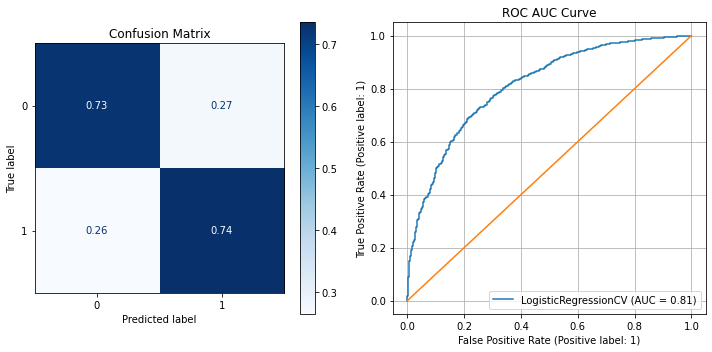

In [175]:
log = fit_eval(LogisticRegressionCV(random_state=123),\
    X_train, y_train,\
        X_test, y_test)

Our out of the box model was good considering we haven't tuned our hyperparameters. We will do that in the furture but now lets discuss what our model returned. We can see that our macro recall score which is calculated by TruePositives / (TruePositives + FalseNegatives) so our logistic regression model accurately predicted about 73.13% or true wins and losses. There is a lot of room to improve since we are inaccurate about 26% of the time. Hopefully tuning our parameters will help. 

# Logistic Regression with GridSearchCV

In our earlier example of the Logistic Regression, we created an instance of our model without passing it any initializers. Instead, we rely on the default values of the various parameters. Lets try and fine tune their values so that our algorithm works best. 

In [159]:
log_grid = LogisticRegression(random_state=123)

# parameter grid
params = {
    'penalty' : ["l1","l2"],
    'C' : np.logspace(-3,3,7),
    'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
    'class_weight': ["balance"],
    
}

log_grid = GridSearchCV(log_grid, params, scoring='recall_macro', cv=10)
log_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=123),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': ['balance'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='recall_macro')

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7316    0.7292    0.7304      3671
           1     0.7349    0.7373    0.7361      3738

    accuracy                         0.7333      7409
   macro avg     0.7333    0.7333    0.7333      7409
weighted avg     0.7333    0.7333    0.7333      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7460    0.7238    0.7347      1278
           1     0.7130    0.7357    0.7242      1192

    accuracy                         0.7296      2470
   macro avg     0.7295    0.7298    0.7295      2470
weighted avg     0.7301    0.7296    0.7296      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


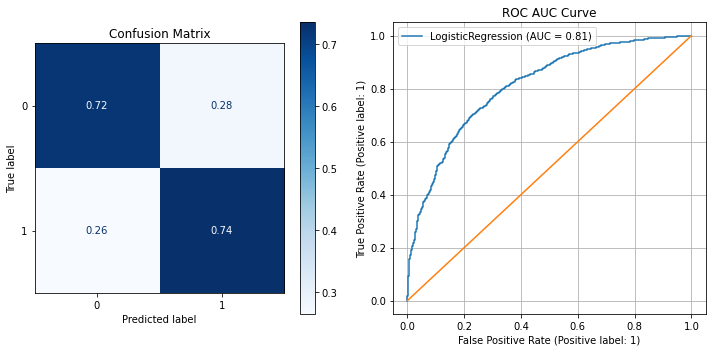

In [160]:
evaluate_model(log_grid.best_estimator_, X_train, y_train,
               X_test, y_test)


After, fine-tunning our hyperparameters we saw a minuscule decrease in our average recall score. I do not want to fall into the overfitting pitfall, let us approach hyperparameter tuning randomly.

# Logistic Regression with RandomSearchCV

In [161]:
log_rand = LogisticRegression()
param_grid = {
     "C": np.arange(0,4,1),
    }

log_rand = RandomizedSearchCV(estimator=log_rand,
                              param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=123, n_jobs=-1)
log_rand.fit(X_train,y_train)



Fitting 10 folds for each of 4 candidates, totalling 40 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([0, 1, 2, 3])},
                   random_state=123, verbose=2)

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7316    0.7292    0.7304      3671
           1     0.7349    0.7373    0.7361      3738

    accuracy                         0.7333      7409
   macro avg     0.7333    0.7333    0.7333      7409
weighted avg     0.7333    0.7333    0.7333      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7460    0.7238    0.7347      1278
           1     0.7130    0.7357    0.7242      1192

    accuracy                         0.7296      2470
   macro avg     0.7295    0.7298    0.7295      2470
weighted avg     0.7301    0.7296    0.7296      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


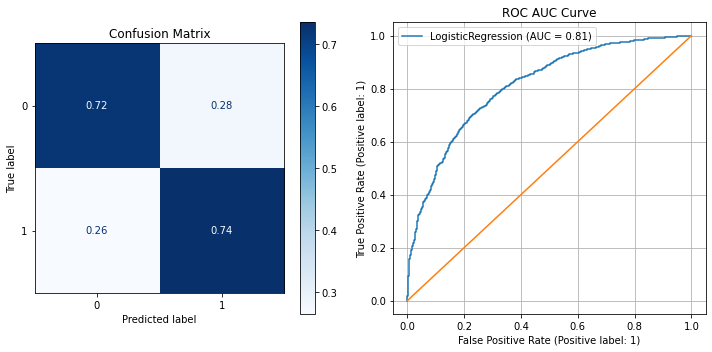

In [162]:
evaluate_model(log_rand.best_estimator_, X_train, y_train,
               X_test, y_test)


We didn't see a significat improvement tuning our parameters using RandomSearchCV vs GridSearchCV. We can see that it was less expensive to run RandomSearchCV in comparasion to GridSearchCV. We'll try a different model to try and more accurate model without overfitting. 

# Random Forest
The model was creating using the original data that was not standardize. 


In [163]:
non_X = non_std_df.loc[:, non_std_df.columns != 'blueWins']
non_y = non_std_df[['blueWins']]


****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3671
           1     1.0000    1.0000    1.0000      3738

    accuracy                         1.0000      7409
   macro avg     1.0000    1.0000    1.0000      7409
weighted avg     1.0000    1.0000    1.0000      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7474    0.7222    0.7346      1278
           1     0.7126    0.7383    0.7252      1192

    accuracy                         0.7300      2470
   macro avg     0.7300    0.7302    0.7299      2470
weighted avg     0.7306    0.7300    0.7300      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


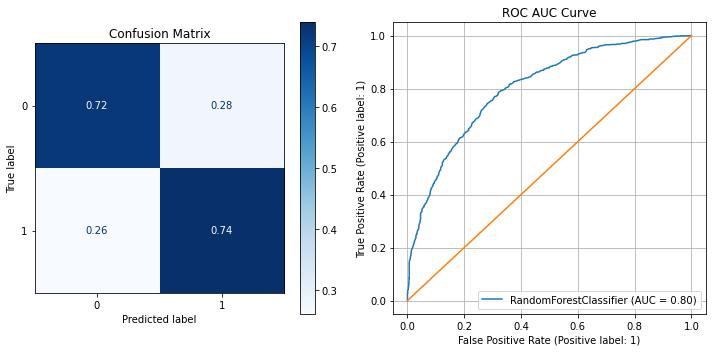

RandomForestClassifier(n_estimators=500, random_state=123)

In [164]:
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(non_X, non_y, test_size=.25, random_state=123)


fit_eval(RandomForestClassifier(random_state=123, n_estimators=500), X_train_non, y_train_non,X_test_non,y_test_non)

Our Random Forest model is scoring perfectly on the training data. This is an evidenct overfitting issue. Lets try to combat the overfitting with some optimal hyperparameter tuning. 